**Chapter 14 – Deep Computer Vision Using Convolutional Neural Networks**
Глава 14 - Глубокое компьютерное зрение с использованием сверточных нейронных сетей

# Установка
Для начала, давайте импортируем несколько общих модулей, убедимся, что MatplotLib строит графики рисунков inline и подготовим функцию для сохранения рисунков. Мы также проверим, установлен ли Python 3.5 или более поздняя версия (хотя Python 2.x может работать, он устарел, поэтому мы настоятельно рекомендуем вам использовать вместо него Python 3), а также Scikit-Learn ≥0.20 и TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
try:
    assert sklearn.__version__ >= "0.20", f'Version {sklearn.__version__} is used. Need another version'
except AssertionError as ex:
    raise
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
try:
    assert tf.__version__ >= "2.0",f'Version {tf.__version__} is used. Need another version'
except AssertionError as ex:
    raise

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Введение

Хотя суперкомпьютер IВМ Deep Вlue победил чемпиона мира по шахма­там Гарри Каспарова еще в 1996 году, до недавнего времени компьютеры не были способны надежно выполнять на вид простые задачи, такие как обна­ружение щенка на фотографии или распознавание сказанных слов. Почему эти задачи настолько легки для нас, людей? Ответ заключается в том, что восприятие в основном происходит за пределами нашего сознания, внутри специализированных зрительных, слуховых и других сенсорных модулей в наших мозгах. К тому времени, когда сенсорная информация достигает на­шего сознания, она уже оснащена высокоуровневыми признаками; например, глядя на фотографию забавного щенка, вы не в состоянии сделать выбор не видеть щенка или не заметить, что он забавный. Вы также не можете объ­яснить, как вы распознали забавного щенка; для вас это просто очевидно. 
Таким образом, мы не можем доверять своему субъективному опыту: вос­приятие вообще не является тривиальным и для его понимания мы должны посмотреть, как работают сенсорные модули. 

Сверточные нейронные сети (Convolиtional Neиral Network - CNN) поя­
вились в результате изучения зрительной коры головного мозга и применя­лись в распознавании изображений, начиная с 1980-х годов. Благодаря росту вычислительной мощности в последние несколько лет, увеличению объема доступных обучающих данных и появлению трюков для обучения глубоких сетей, которые были представлены в главе 11, сетям CNN удалось достичь сверхчеловеческой производительности при решении ряда сложных зритель­ных задач. Они приводят в действие мощные службы поиска изображений, беспилотные автомобили, системы автоматической классификации видеоро­ликов и т.п. Кроме того, сети CNN не ограничиваются зрительным воспри­ятием: они также успешно решают другие задачи вроде распознавания речи 
(voice recognition) или обработки естественного языка (Natural Language 
Processing - NLP); однако пока что мы сосредоточимся на зрительных упот­реблениях. 

В этой главе мы рассмотрим, откуда взялись CNN, как выглядят их строительные блоки и как их реализовать с помощью TensorFlow и Keras. Затем мы обсудим некоторые из лучших архитектур CNN, а также другие визуальные задачи, включая обнаружение объектов (классификация нескольких объектов на изображении и размещение вокруг них ограничивающих рамок) и семантическую сегментацию (классификация каждого пикселя в соответствии с классом объекта, к которому он принадлежит).

# Строение зрительной коры головноrо мозrа 
Дэвид Х. Хьюбел и Торстен Визель провели серию экспериментов на кош­ках в 1958 и 1959 годах (а спустя несколько лет также на обезьянах), вы­явив важнейшие сведения о структуре зрительной коры головного мозга (в 1981 году авторы получили за свою работу Нобелевскую премию в об­ласти физиологии или медицины). В частности, они показали, что многие нейроны в зрительной коре имеют небольшое локальное рецепторное поле (local receptive field), а потому реагируют на зрительные раздражители, на­ходящиеся в ограниченной области поля зрения (на рис. 14-1 локальные ре­цепторные поля пяти нейронов представлены пунктирными окружностями). 
Рецепторные поля разных нейронов могут перекрываться и вместе они ох­ватывают все поле зрения. Вдобавок авторы продемонстрировали, что неко­торые нейроны реагируют только на изображения горизонтальных линий, в то время как другие - на линии в разных направлениях (два нейрона могут иметь одно и то же рецепторное поле, но реагировать на линии с отличаю­щимися направлениями). Они также заметили, что некоторые нейроны об­ладают большими рецепторными полями и реагируют на более сложные об­разы, являющиеся комбинациями низкоуровневых образов. Эти наблюдения привели к мысли о том, что нейроны более высокого уровня основываются на выходах соседствующих нейронов более низкого уровня (обратите внима­ние на рис. 14-1, что каждый нейрон связан только с несколькими нейронами из предыдущего уровня). Такая мощная архитектура способна обнаруживать все виды сложных образов в любой области поля зрения. 
<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 5%;
  margin: 0 auto;
  float: left;
  width: content;
  style: left
  

}
figure.img2 figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}

</style>

<figure class="img">
    <img 
    src="./images/book/img1.png"
    alt="">
    <figcaption>
    Рис 14-1. Биологические нейроны в зрительной коре реагируют на определенные паттерны в небольших областях поля зрения, называемых рецептивными полями; по мере того как визуальный сигнал проходит через последовательные модули мозга, нейроны реагируют на более сложные паттерны в более крупных рецептивных полях.    
    </figcaption>
</figure>

Проведенные исследования зрительной коры вдохновили на создание в 1980 году неокогнитрона (neocognitron), который постепенно развился в то, что сейчас мы называем сверточными нейронными сетями. Важной вехой стала работа 1998 года Яна Лекуна, Леона Батту, Йошуа Бенджи и Патрика Хаффнера, в которой была введена знаменитая архитектура LeNet-5, широко применяемая для распознавания рукописных чисел на чеках. Эта архитекту­ра содержит ряд строительных блоков, которые вам уже известны, в том чис­ле полносвязные слои и сигмоидальные функции активации, но она также представляет два новых строительных блока: сверточные слои ( convolutional 
layer) и объединяющие слои (pooling layer). Давайте рассмотрим их. 

<figure class="img2">
    <img 
    src="./images/book/bird.png"
    alt="">
</figure>
<p style="margin-left: 100px"> 
Почему для решения задач распознавания изображений просто не воспользоваться обыкновенной глубокой нейронной сетью с полносвязными слоями? К сожалению, хотя она хорошо работа­ет для небольших изображений (скажем, MNIST), в случае более крупных изображений ее работа нарушается из-за гигантского количества требующихся параметров. Например, изображение 100 х 100 содержит 1ОООО пикселей, и если первый слой имеет лишь 1ООО нейронов (что уже серьезно ограничивает объем ин­формации, передаваемой следующему слою), то в итоге получится 10 миллионов связей. И это только первый слой. Сети CNN реша­ют такую проблему с применением частично связных слоев.
</p>




# Сверточный слой
Самый важный строительный блок сети CNN - это сверточный слой: нейроны в первом сверточном слое не связаны с каждым одиночным пиксе­лем во входном изображении (как было в предшествующих главах), а только с пикселями в собственных рецепторных полях (рис. 14-2). В свою очередь каждый нейрон во втором сверточном слое связан только с нейронами, на­ходящимися внутри небольшого прямоугольника в первом слое. Такая ар­хитектура позволяет сети сосредоточиться на низкоуровневых признаках в первом скрытом слое, затем скомпоновать их в признаки более высокого уровня в следующем скрытом слое и т.д. Подобная иерархическая структура распространена в реальных изображениях, что и является одной из причин, почему сети CNN настолько хорошо работают при распознавании изобра­жений.

Свертка - это математическая операция, которая плавно перемещает одну функцию по другой и измеряет интеграл их точечного умножения. Она имеет глубинные связи с преобразованием Фурье и преобразованием Лапласа и интенсивно используется в обработке сигналов. Сверточные слои на самом деле применяют взаимную корреля­цию, которая очень похожа на свертку.
<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 5%;
  margin: 0 auto;
  float: left;
  width: content;
  

}
figure.img2 figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img2.png"
    alt="">
    <figcaption>
    Рис 14-2. Слои сети CNN с прямоугольными локальными рецепторными полями.    
    </figcaption>
</figure>

$\quad$
<figure class="img2">
    <img 
    src="./images/book/bird.png"
    alt="">
</figure>
<p style="margin-left: 100px">
Все рассмотренные до сих пор многослойные нейронные сети имели слои, состоящие из длинной линейки нейронов, и нам приходилось разглаживать входные изображения до одного измерения, прежде чем передавать их нейронной сети. Теперь каждый слой представлен в двух измерениях, что облегчает со­поставление нейронов с соответствующими им входами.
</p>

$\quad$

Нейрон, расположенный в строке $i$ и столбце $j$ заданного слоя, связыва­ется с выходами нейронов предыдущего слоя, которые находятся в строках с $i$ по $i + f_h - 1$ и столбцах с $j$ по $j + f_w - 1$, где $f_h$ и $f_w$  - высота и ширина ре­цепторного поля (рис. 14-3). Для того чтобы слой имел такую же высоту и ширину, как у предыдущего слоя, вокруг входов обычно добавляют нули, что и видно на рис. 14-3. Это называется дополнением нулями (zero padding). 

<figure class="img">
    <img 
    src="./images/book/img3.png"
    alt="">
    <figcaption>
    Рис 14-3. Связи между слоями и дополнение нулями.    
    </figcaption>
</figure>

Также можно связать крупный входной слой с гораздо меньшим слоем, растягивая рецепторные поля (рис. 14-4). Расстояние между двумя после­довательными рецепторными полями называется страйдом (stride), или большим шагом. На рис. 13-4 входной слой 5 х 7 (плюс дополнение нуля­ми) связывается со слоем 3 х 4, используя рецепторные поля 3 х 3 и страйд 2 (в данном примере страйд одинаков в двух направлениях, но он вовсе не обязан быть таким). Нейрон, расположенный в строке $i$ и столбце $j$ более вы­сокого слоя, связывается с выходами нейронов предыдущего слоя, которые находятся в строках с $i \times s_h$ по $i \times s_h + f_h - 1$ и столбцах с $j \times s_w$ по $j \times s_w + f_w - 1$, где $s_h$ и $s_w$ - вертикальный и горизонтальный страйды. 

<figure class="img">
    <img 
    src="./images/book/img4.png"
    alt="">
    <figcaption>
    Рис 14-4. Понижение размерности с применением страйда 2.    
    </figcaption>
</figure>


# Фильтры
Веса нейронов могут быть представлены как небольшие изображения с размером рецепторного поля. Например, на рис. 14-5 показаны два возмож­
ных набора весов, называемые фильтрами filter) или сверточными ядрами 
(convolution kernel). Первый фильтр представлен в виде черного квадрата с вертикальной белой линией в середине (это матрица 7 х 7, которая заполне­на нулями за исключением центрального столбца, заполненного единицами); нейроны, использующие такие веса, будут игнорировать в своем рецептор­ном поле все кроме центральной вертикальной линии (потому что все вхо­ды будут умножаться на О за исключением входов, расположенных на цент­ральной вертикальной линии). Второй фильтр имеет вид черного квадрата с горизонтальной белой линией в середине. И снова нейроны, использующие такие веса, будут игнорировать в своем рецепторном поле все кроме цент­ральной горизонтальной линии. 

Теперь если все нейроны в слое используют один и тот же фильтр с вер­тикальной линией (и тот же самый член смещения), и вы передаете сети входное изображение, приведенное на рис. 14-5 (нижнее изображение), то слой выдаст левое верхнее изображение. Обратите внимание, что верти­кальные белые линии усилились, в то время как остальное стало размытым.Аналогично правое верхнее изображение представляет собой то, что будет получено, если все нейроны применяют фильтр с горизонтальной линией;заметно, что горизонтальные белые линии усилились, а остальное стало раз­мытым. Таким образом, слой с нейронами, использующими один и тот же фильтр, выдает карту признаков (feature mар), которая выделяет области изображения, наиболее сходные с фильтром. Во время обучения сеть CNN находит самые пригодные фильтры для своей задачи и учится комбиниро­вать их в более сложные образы (скажем, крест является областью, где ак­тивны оба фильтра - с вертикальной линией и с горизонтальной линией).

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img5.png"
    alt="">
    <figcaption>
    Рис 14-5. Применение двух разных фильтров для получения карт признаков.    
    </figcaption>
</figure>


# Наложение множества карт признаков
До сих пор ради простоты мы представляли каждый сверточный слой как тонкий двумерный слой, но в реальности он состоит из нескольких карт признаков равных размеров, поэтому более точно представляется в трех из­мерениях (рис. 14-6). Внутри одной карты признаков все нейроны разделяют те же самые параметры (веса и член смещения), но разные карты признаков могут иметь отличающиеся параметры. Рецепторное поле нейрона такое же, как описано ранее, но оно распространяется на все карты признаков пред­шествующих слоев. Короче говоря, сверточный слой одновременно применя­ет множество фильтров к своим входам, становясь способным обнаруживать множество признаков повсюду в своих входах. 

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 5%;
  margin: 0 auto;
  float: left;
  width: content;
  

}
figure.img2 figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>


<figure class="img2">
    <img 
    src="./images/book/bird.png"
    alt="">
</figure>
<p style="margin-left: 100px">
Тот факт, что все нейроны в карте признаков разделяют те же самые параметры, значительно сокращает количество пара­метров в модели, но более важно то, что после обучения сети CNN распознаванию образа в одном положении, она способна распознавать его в любом другом положении. Напротив, после того, как обыкновенная сеть DNN обучена распознаванию об­раза в одном положении, она может распознавать его только в этом конкретном положении.
</p>

$\quad$

Кроме того, входные изображения также состоят из множества подсло­ев: по одному на цветовой канал. Их обычно три: красный, зеленый и си­ний (red, green, Ыuе - RGB). Полутоновые изображения имеют только один канал, но некоторые изображения могут иметь гораздо больше каналов -например, изображения со спутников, фиксирующие свет дополнительных частот (такой как инфракрасный). 
<figure class="img">
    <img 
    src="./images/book/img6.png"
    alt="">
    <figcaption>
    Рис 14-6. Сверточные слои с множеством карт признаков и изображения с тремя каналами.    
    </figcaption>
</figure>

В частности, нейрон, расположенный в строке $i$ и столбце $j$ карты при­знаков $k$ в заданном сверточном слое $l$, связывается с выходами нейронов в предыдущем слое $l - 1$, который находится в строках с $i \times s_h$ по $i \times s_h + f_h - 1$ и столбцах с $j \times s_w$ по $j \times s_w + f_w - 1$ через все карты признаков (в слое $l - 1$).Обратите внимание, что все нейроны, расположенные в той же самой строке $i$ и столбце $j$, но в разных картах признаков, связываются с выходами точно тех же нейронов в предыдущем слое. 

В уравнении 14-1 приведенные объяснения подытоживаются в одно боль­шое математическое уравнение: оно показывает, как вычислять выход задан­ного нейрона в сверточном слое. Из-за обилия разных индексов уравнение выглядит несколько неуклюжим, но все, что оно делает - вычисляет взве­шенную сумму всех входов плюс член смещения. 

Уравнение 14-1. Вычисление выхода нейрона в сверточном слое \
$z_{i,j,k} = b_k + \sum \limits _{u=0} ^{f_h-1} \sum \limits _{v=0} ^{f_w-1} \sum \limits _{k^{'}=0} ^{f_{n^{'}}-1} x_{i^{'},j^{'},k^{'}} \cdot w_{u,v,k^{'},k} \quad с \quad \begin{cases} i^{'} = i \times s_h + u \\ j^{'} = j \times s_w + v \end{cases} \hspace{180pt} \text{(14-1)}$

- $z_{i,j,k}$ - выход нейрона, расположенного в строке $i$ и столбце $j$ в карте признаков $k$ сверточного слоя (слоя $l$). 
- Как объяснялось ранее, $s_h$ и $s_w$ - вертикальный и горизонтальный страйды, $f_h$ и $f_w$ - высота и ширина рецепторного поля, а $f_{п^{'}}$ - коли­чество карт признаков в предыдущем слое (слое $l - 1$).
- $x_{i^{'},j^{'},k^{'}}$ - выход нейрона, расположенного в слое $l - 1$, строка $i^{'}$, столбец $j^{'}$, карта признаков $k^{'}$ (или канал $k^{'}$, если предыдущий слой является вход­ным).
- $b_k$ - член смещения для карты признаков $k$ (в слое $l$). Вы можете ду­мать об этом как о ручке управления, которая регулирует общую яр­кость карты признаков $k$.
- $w_{u,v,k^{'},k}$ - вес связи между любым нейроном в карте признаков $k$ слоя $l$ и его входом, расположенным в строке $u$, столбце $v$ (относительно ре­цепторного поля нейрона) и карте признаков $k^{'}$. 


# Реализация с помощью TensorFlow

В TensorFlow каждое входное изображение обычно представляется как трехмерный тензор в форме [высота, ширина, каналы]. Мини-пакет пред­ставляется как четырехмерный тензор в форме [размер мини-пакета, высота, ширина, каналы]. Веса сверточного слоя представляются как четырехмерный тензор в форме [$f_h, f_w, f_{n^{'}}, f_n$]. Члены смещения сверточного слоя представля­ются просто как одномерный тензор в форме [$f_n$]. 

Давайте рассмотрим простой пример. Приведенный ниже код загружает два примера изображений, используя функцию `load_sample_images()` из Scikit-Learn (которая загружает два цветных изображения, одно с храмом и одно с цветком). Затем код создает два фильтра 7 х 7 и применяет их к обоим изображениям с использованием сверточного слоя и, наконец, код показывает результат.

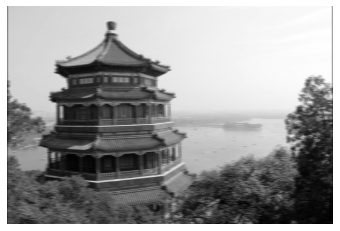

In [2]:
from sklearn.datasets import load_sample_image

# Загрузка изображений
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Создание двух фильтров
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # Вертикальная линия
filters[3, :, :, 1] = 1  # Горизонтальная линия

# Сверточный слой
# strides = 1 or strides = [1,1,1,1]
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") 
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()


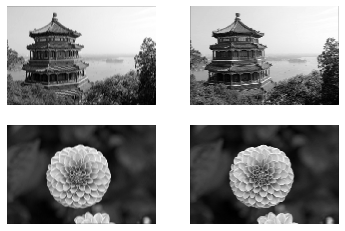

In [3]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [4]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


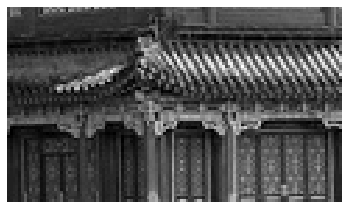

Saving figure china_vertical


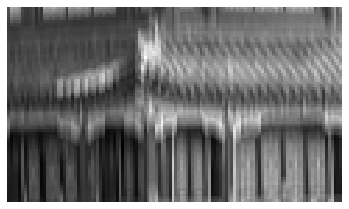

Saving figure china_horizontal


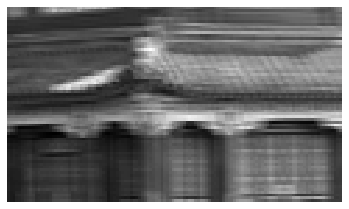

In [5]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

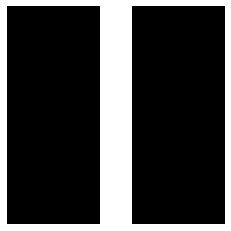

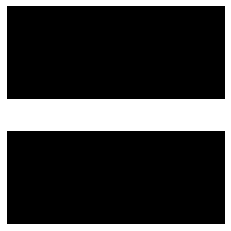

In [13]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

Давайте пройдемся по этому коду:
- Интенсивность пикселя для каждого цветового канала представлена в виде байта от 0 до 255, поэтому мы масштабируем эти функции, просто разделив их на 255, чтобы получить значения с плавающей запятой в диапазоне от 0 до 1.
- Затем мы создаем два фильтра 7 × 7 (один с вертикальной белой линией посередине, а другой с горизонтальной белой линией посередине).
- Мы применяем два фильтра к обоим изображениям с помощью функции `tf.nn.conv2d()`, которая является частью низкоуровневого API глубокого обучения TensorFlow. В этом примере мы используем нулевой отступ (`padding="SAME"`) и шаг 1 (`stride=1`).
- Наконец, мы вычерчиваем одну из карт признаков первого изображения.

Строка `tf.nn.conv2d()` заслужи­вает некоторых пояснений:
- `images` - входной мини-пакет (четырехмерный тензор, как объяснялось ранее).
- `filters` - набор фильтров, подлежащих применению (также четы­рехмерный тензор, как объяснялось ранее). 
- `strides` - шаг рецепторного поля ($s_h$ и $s_w$) равный 1, но это может быть четырехэлементный одномерный массив, где два централь­ных элемента представляют собой вертикальный и горизонтальный страйды ($s_h$ и $s_w$). Первый и последний элементы в текущий момент должны быть равны 1. В один прекрасный день они могут использо­ваться для указания страйда пакета (чтобы пропускать некоторые об­разцы) и страйда канала (чтобы пропускать некоторые карты призна­ков или каналы предыдущего слоя).
- `padding` - должен быть установлен либо в "VALID", либо в "SАМЕ":
   - Если `padding` установлен в "SАМЕ", то сверточный слой при необ­ходимости использует дополнение нулями. В таком случае количес­тво выходных нейронов равно числу входных нейронов, деленному на страйд, с округлением в большую сторону. Например, если входной размер равен 13, а страйд равен 5 (рис. 14-7), то выходной размер равен 3 (т.е. 13/5 = 2,6, округленное до 3).  Затем вокруг входов как можно более равномерно добавляются нули. Когда страйд равен 1, выходной слой будет иметь те же пространственные размеры (ширину и высоту), что и его входной слой, отсюда и название такой-же(same). 
   - Если `padding` установлен в "VALID", то сверточный слой не задейс­твует дополнение нулями и может игнорировать некоторые строки и столбцы внизу и справа входного изображения в зависимости от страйда, как демонстрируется на рис. 14-7 (для простоты здесь пока­зано только горизонтальное измерение, но, само собой разумеется, та же самая логика применима и к вертикальному измерению). Это означает, что рецептивное поле каждого нейрона находится строго в допустимых позициях внутри входных данных (оно не выходит за границы), отсюда и название допустимое(valid).


<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img7.png"
    alt="">
    <figcaption>
    Рис 14-7. Варианты дополнения - ширина входа: 13, ширина фильтра: 6, страйд: 5.    
    </figcaption>
</figure>

В этом примере мы вручную определили фильтры, но в реальной CNN вы обычно определяете фильтры как обучаемые переменные, чтобы нейронная сеть могла узнать, какие фильтры работают лучше всего. Вместо создания переменных вручную используйте слой `keras.layers.Conv2D`.

`conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")`

Этот код создает слой Conv2D с 32 фильтрами, каждый 3 × 3, используя шаг 1 (как по горизонтали, так и по вертикали) и «SAME» дополнение, а также применяя функцию активации ReLU к своим выходам. Как видите, сверточные слои имеют довольно много гиперпараметров: вы должны выбрать количество фильтров, их высоту и ширину, шаг и тип заполнения. Как всегда, вы можете использовать перекрестную проверку, чтобы найти правильные значения гиперпараметров, но это требует очень много времени. Мы обсудим распространенные архитектуры CNN позже, чтобы дать вам некоторое представление о том, какие значения гиперпараметров лучше всего работают на практике.

Давайте создадим 2D сверточный слой, используя `keras.layers.Conv2D()`:

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
 padding="SAME", activation="relu", input_shape=outputs.shape)

Назовем этот слой, передав ему два тестовых изображения:

In [26]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

Выход представляет собой четырехмерный тензор. Размеры: размер мини-пакета, высота, ширина, каналы. Первое измерение (размер пакета) равно 2, так как есть 2 входных изображения. Следующие два измерения — это высота и ширина выходных карт объектов: поскольку `padding="SAME"` и `strides=1`, выходные карты объектов имеют ту же высоту и ширину, что и входные изображения (в данном случае 427 × 640). Наконец, этот сверточный слой имеет 2 фильтра, поэтому последнее измерение равно 2: для каждого входного изображения есть 2 выходные карты призакнов.

Поскольку фильтры инициализируются случайным образом, они изначально будут обнаруживать случайные шаблоны. Давайте посмотрим на две выходные карты признаков для каждого изображения:

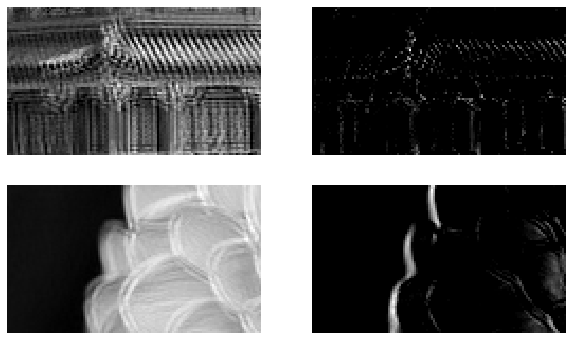

In [27]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Хотя фильтры были инициализированы случайным образом, второй фильтр действует как детектор границ. Случайно инициализированные фильтры часто действуют таким образом, что весьма удачно, поскольку обнаружение краев весьма полезно при обработке изображений. Если мы хотим, мы можем установить фильтры так, как мы вручную определили ранее, и установить смещения на нули (в реальной жизни нам почти никогда не потребуется устанавливать фильтры или смещения вручную, поскольку сверточный слой просто выучит соответствующие фильтры и смещения во время обучения):

In [28]:
conv.set_weights([filters, np.zeros(2)])

Теперь давайте снова вызовем этот слой для тех же двух изображений и проверим, что выходные карты объектов выделяют вертикальные и горизонтальные линии соответственно (как и ранее):

In [29]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

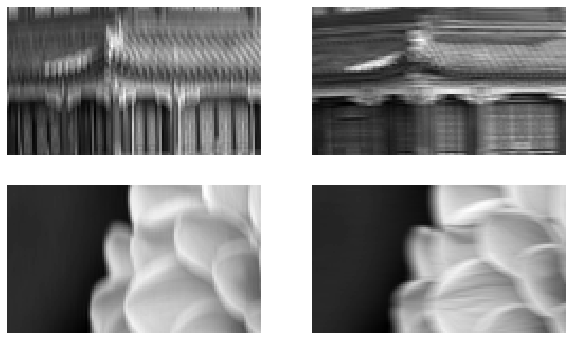

In [30]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

Сравним дополнения `valid` и `same`:

In [43]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images


Использование дополнение `"SAME"` эквивалентно дополнение вручную с помощью `manual_same_padding()`, а затем использованию дополнения `"VALID"` (как ни странно, заполнение `"VALID"` означает полное отсутствие дополнения):

In [44]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())


# Требования к памяти

Еще одна проблема сетей CNN заключается в том, что сверточные слои требуют огромного объема оперативной памяти, особенно во время обуче­ния, поскольку при проходе назад обратного распространения нужны все промежуточные значения, вычисленные в течение прохода вперед. 

Например, возьмем сверточный слой с фильтрами 5 х 5, выдающий 200 карт признаков размером 150 х 100, со страйдом 1 и дополнением "SАМЕ". Если на вход передается RGВ-изображение 150 х 100 (три канала), тогда количество параметров составляет (5 х 5 х 3 + 1) х 200 = 15200 ( + 1 соответ­ствует членам смещения (bias)), что достаточно немного в сравнении с полносвяз­ным слоем (Полносвязный слой с 150 х 100 нейронами, каждый из которых связан со всеми 150 х 100 х 3 входами, имел бы $150^2$ х $100^2$ х 3 = 675 миллионов параметров). Тем не менее, каждая из 200 карт признаков содержит 150 х 100 нейронов, а каждый нейрон нуждается в вычислении взвешенной суммы своих 5 х 5 х 3 = 75 входов: всего 225 миллионов операций умножения с пла­вающей точкой. Не настолько плохо, как у полносвязного слоя, но все-таки достаточно интенсивно в вычислительном отношении. Кроме того, если кар­ты признаков представлены с применением 32-битовых значений с плаваю­щей точкой, то выход сверточного слоя будет занимать 200 х 150 х 100 х 32 = 96 миллионов битов (около 11.4 Мбайт) оперативной памяти. И это лишь для одного образца! Если обучающий пакет содержит 100 образцов, тогда дан­ный слой будет использовать свыше 1 Гбайт оперативной памяти!

Во время выведения (т.е. выработки прогноза для нового образца) опера­тивная память, занятая одним слоем, может быть освобождена, как только вычислен следующий слой, поэтому оперативной памяти необходимо иметь столько, сколько требуется для двух последовательных слоев. Но во время обучения все, что вычисляется в течение прохода вперед, должно быть со­хранено для прохода назад, а потому оперативной памяти нужно (по край­ней мере) столько, сколько ее требуется для всех слоев. 


<style>

figure.img2{
  max-width: 5%;
  margin: 0 auto;
  float: left;
  width: content;
}
</style>


<figure class="img2">
    <img 
    src="./images/book/monk.png"
    alt="">
</figure>
<p style="margin-left: 100px">
Если обучение терпит неудачу из-за ошибки, вызванной нехват­кой памяти, тогда вы можете попробовать сократить размер мини-пакета. В качестве альтернативы вы можете попытаться понизить размерность с применением страйда или удалить не­сколько слоев. Либо вы можете использовать 16-битовые значения с плавающей точкой вместо 32-битовых. Или же можете распределить сеть CNN между множеством устройств. 
</p>

$\quad$

А теперь давайте посмотрим на второй общий строительный блок в сетях 
CNN: объединяющий слой. 




# Объединяющий слой

Разобравшись в том, как работают сверточные слои, понять назначение объединяющих слоев (называемых также субдискретизирующими слоями или слоями подвыборки - примеч. пер.) довольно легко. Их цель заключает­ся в том, чтобы проредить (т.е. сжать) входное изображение для сокращения вычислительной нагрузки, расхода памяти и количества параметров (тем са­мым ограничивая риск переобучения). 

Как и в сверточных слоях, каждый нейрон в объединяющем слое связан с выходами ограниченного числа нейронов из предыдущего слоя, которые рас­положены внутри небольшого прямоугольного рецепторного поля. Вы должны определить его размер, страйд и тип дополнения, точно как раньше. Однако объединяющий нейрон не имеет весов; он лишь агрегирует входы с примене­нием функции агрегирования, такой как максимум или среднее. На рис. 14-8 показан слой объединения по максимуму (max pooling layer), который является самым распространенным типом объединяющего слоя. В данном примере мы используем объединяющее ядро (pooling kernel) 2 х 2, страйд 2, без дополнения. Обратите внимание, что на следующий слой попадает только максимальное входное значение в каждом ядре. Остальные входы отбрасываются. Например, в нижнем левом рецептивном поле на рис. 14-8 входными значениями являются 1, 5, 3, 2, поэтому на следующий уровень передается только максимальное значение 5. Из-за шага, равного 2, выходное изображение имеет половину высоты и половину ширины входного изображения (округлено в меньшую сторону, поскольку мы не используем отступы).

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 5%;
  margin: 0 auto;
  float: left;
  width: content;
  

}
figure.img2 figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img8.png"
    alt="">
    <figcaption>
    Рис 14-8. Слой объединения по максимуму (объединяющее ядро 2 х 2, страйд 2, без дополнения).    
    </figcaption>
</figure>

$\quad$
<figure class="img2">
    <img 
    src="./images/book/bird.png"
    alt="">
</figure>
<p style="margin-left: 100px">
Слой объединения обычно работает с каждым входным каналом независимо, поэтому глубина вывода совпадает с глубиной ввода.
<br>
<br>
<br>
<br>
</p>

Помимо сокращения объема вычислений, использования памяти и количества параметров, уровень максимального объединения также вводит некоторый уровень инвариантности к малым трансляциям, как показано на рис. 14-9. Здесь мы предполагаем, что яркие пиксели имеют более низкое значение, чем темные пиксели, и мы рассматриваем три изображения (A, B, C), проходящие через максимальный объединяющий слой с ядром 2 × 2 и шагом 2. Изображения B и C такие же, как изображение A, но смещены на один и два пикселя вправо. 

Как видите, выходные данные слоя максимального объединения для изображений A и B идентичны. Это и означает трансляционная инвариантность. Для изображения C результат другой: он сдвинут на один пиксель вправо (но по-прежнему сохраняется 75% инвариантность). Вставляя максимальный объединяющий слой каждые несколько слоев в CNN, можно получить некоторый уровень трансляционной инвариантности в большем масштабе. Более того, максимальное объединение предлагает небольшую инвариантность к вращению и небольшую инвариантность к масштабу. Такая инвариантность (даже если она ограничена) может быть полезна в случаях, когда предсказание не должно зависеть от этих деталей, например, в задачах классификации.

<figure class="img">
    <img 
    src="./images/book/img9.png"
    alt="">
    <figcaption>
    Рис 14-9. Инвариантность к малым трансляциям.    
    </figcaption>
</figure>

Очевидно, это крайне деструктивный вид слоя: даже с крошечным ядром 2 х 2 и страйдом 2 выход будет в два раза меньше в обоих направлениях (так что его площадь окажется в четыре раза меньше) из-за простого отбрасыва­ния 75% входных значений. А в некоторых приложениях инвариантность нежелательна. Возьмем семантическую сегментацию (задача классификации каждого пикселя изображения в соответствии с объектом, которому этот пиксель принадлежит, который мы рассмотрим позже в этой главе): очевидно, если входное изображение сдвинуто на один пиксель вправо, выходное изображение также должно быть сдвинуто на один пиксель вправо. Целью в этом случае является эквивариантность, а не инвариантность: небольшое изменение на входе должно привести к соответствующему небольшому изменению на выходе.

# Реализация TensorFlow
Реализовать слой объединения по максимуму в TensorFlow довольно лег­ко. Следующий код создает слой объединения по максимуму, используя ядро 2 х 2, страйд 2, без дополнения, и затем применяет его ко всем изображениям в наборе данных:

In [45]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [46]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


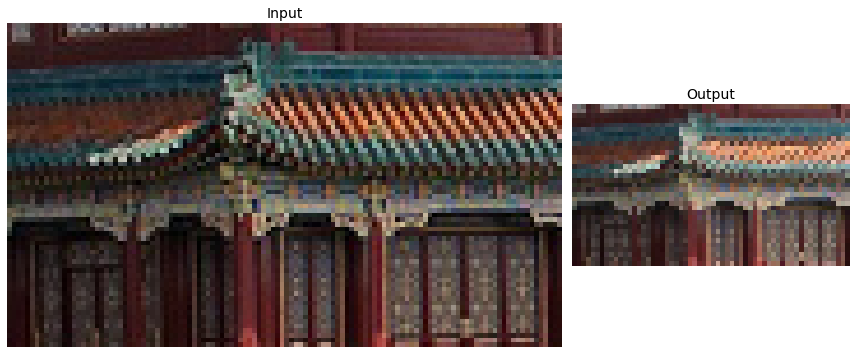

In [47]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

Чтобы создать слой обьединения по среднему, просто используйте AvgPool2D вместо MaxPool2D. Как и следовало ожидать, он работает точно так же, как слой обьединения по максимуму, за исключением того, что он вычисляет среднее, а не максимальное значение. Слой обьединения по среднему раньше были очень популярны, но сейчас люди в основном используют слой обьединения по максимуму, поскольку они обычно работают лучше. Это может показаться удивительным, поскольку при вычислении среднего обычно теряется меньше информации, чем при вычислении максимального значения. Но, с другой стороны, максимальное объединение сохраняет только самые сильные признаки, избавляясь от всех бессмысленных, поэтому следующие слои получают более чистый сигнал для работы. Кроме того, обьединение по максимуму обеспечивает более высокую инвариантность к переводу, чем обьединение по среднему, и требует немного меньше вычислений.

Объединение по среднему

In [50]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [51]:
output_avg = avg_pool(cropped_images)

Saving figure china_avg_pooling


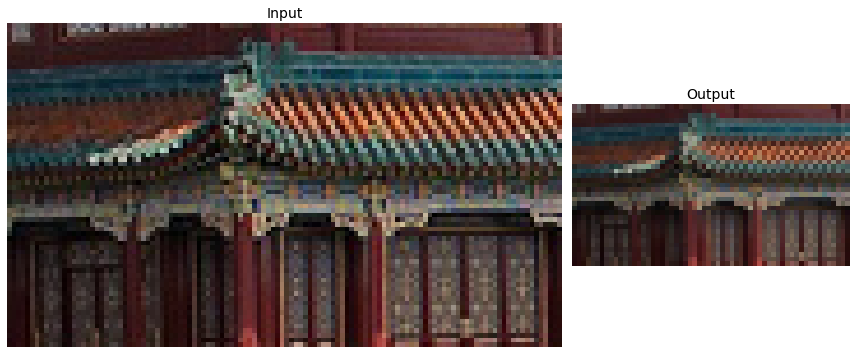

In [55]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_avg_pooling")
plt.show()


Обратите внимание, что объединение максимального и среднего значений может выполняться по измерению глубины, а не по пространственному измерению, хотя это не так распространено. Это может позволить CNN научиться быть инвариантной к различным функциям.Например, он может обучить несколько фильтров, каждый из которых будет обнаруживать разное вращение одного и того же шаблона (например, рукописные цифры; см. рис. 14-10), а слой максимального объединения по глубине гарантирует, что выходные данные будут одинаковыми независимо от поворота. Точно так же CNN может научиться быть инвариантной ко всему остальному: толщине, яркости, перекосу, цвету и так далее.
<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img10.png"
    alt="">
    <figcaption>
    Рис 14-10. Глубинное максимальное объединение может помочь CNN изучить любую инвариантность.    
    </figcaption>
</figure>


Keras не включает слой объединение по максимуму по глубине, но низкоуровневый API глубокого обучения TensorFlow включает: просто используйте функцию `tf.nn.max_pool()` и укажите размер ядра и шаги в виде кортежей (т. е. кортежей размера 4). Первые три значения каждого из них должны быть равны 1: это означает, что шаг по размеру пакета и размер ядра (высота и ширина) должны быть равны 1. Последнее значение должно быть любым размером ядра и шагом, который вы хотите по измерению глубины, например - 3. (это должен быть делитель входной глубины; он не будет работать, если предыдущий слой выводит 20 карт объектов, так как 20 не кратно 3):

Глубинное объединение каналов по максимуму каждого минипакета

In [95]:
# собственный слой Keras:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

Размер изображения не имзенился. Объедение было по максимальным значениям всех каналов,  каждого изображения
(2, 70, 120, 1)
Saving figure china_depthwise_max__pooling


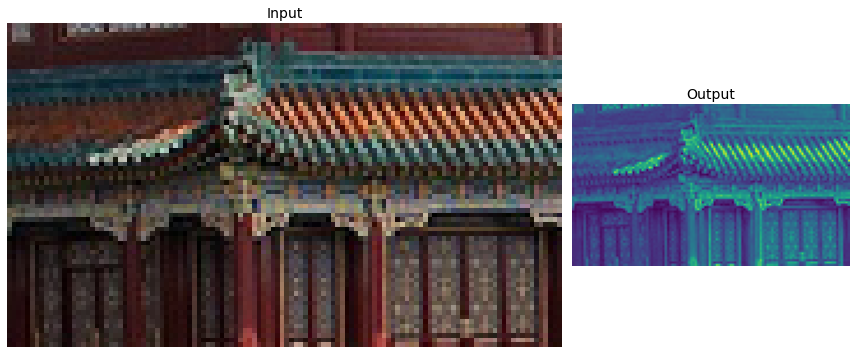

In [115]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    try:
        depth_output = depth_pool(cropped_images)
    except Exception:
        print('Размер шага глубины не кратен колличеству каналов изображения')
        raise
print('Размер изображения не имзенился.\
 Объедение было по максимальным значениям всех каналов, \
 каждого изображения')
print(depth_output.shape)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(depth_output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_depthwise_max__pooling")
plt.show()

Если вы хотите включить это как слой в свои модели Keras, оберните его слоем Lambda

In [102]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

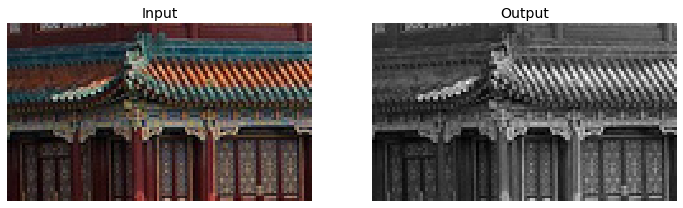

In [106]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

Последний тип слоя объединения, который вы часто будете видеть в современных архитектурах, — это глобальный слой обьеденения по среднему. Он работает совсем по-другому: все, что он делает, — это вычисляет среднее значение каждой карты признаков целиком (это похоже на слой объединения по среднему, использующий ядро объединения с теми же пространственными размерами, что и входные данные). Это означает, что он просто выводит одно число для каждой карты признаков и для каждого экземпляра. Хотя это, конечно, чрезвычайно разрушительно (большая часть информации в карте признаков теряется), она может быть полезна в качестве выходного слоя, как мы увидим позже в этой главе. Чтобы создать такой слой, просто используйте класс `keras.layers.GlobalAvgPool2D`:

In [116]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool_out = global_avg_pool(cropped_images)
print(f'Начальной тензор: {cropped_images.shape}')
print(f'Тензор полсе глобального объединения по среднему: {global_avg_pool_out.shape}')

Начальной тензор: (2, 70, 120, 3)
Тензор полсе глобального объединения по среднему: (2, 3)


Это эквивалентно этому простому лямбда-слою, который вычисляет среднее значение по пространственным измерениям (высоте и ширине):

In [117]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
global_avg_pool_out2=output_global_avg2(cropped_images)
print(f'Начальной тензор: {cropped_images.shape}')
print(f'Тензор полсе глобального объединения по среднему: {global_avg_pool_out2.shape}')

Начальной тензор: (2, 70, 120, 3)
Тензор полсе глобального объединения по среднему: (2, 3)


Теперь вы знаете все строительные блоки для создания сверточных нейронных сетей. Давайте посмотрим, как их собрать.

# Архитектуры сверточных нейронных сетей

Типовая архитектура сети CNN укладывает стопкой несколько сверточ­ных слоев (за каждым из которых следует слой ReLU), объединяющий слой, еще несколько сверточных слоев (плюс слои ReLU), снова объединяющий слой и т.д. По мере прохождения через сеть изображение становится все меньше и меньше, но обычно также глубже и глубже (т .е. с большим чис­лом карт признаков) благодаря сверточным слоям (рис. 14-11). На верхушку стопки добавляется обыкновенная нейронная сеть прямого распростране­ния, состоящая из нескольких полносвязных слоев (плюс слоев ReLU), и фи­нальный слой выдает прогноз (например, многопеременный слой, который выдает оценочные вероятности классов).

<style>
figure.img {
  max-width: 60%;
  margin: 0 auto;
  text-align: center;
  width: content; 

}
figure.img figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
figure.img2{
  max-width: 5%;
  margin: 0 auto;
  float: left;
  width: content;
  

}
figure.img2 figcaption {  /* стиль описания */
  padding: 0 1%;
  font: italic 100% Georgia,serif;
  text-align: left;
}
</style>

<figure class="img">
    <img 
    src="./images/book/img11.png"
    alt="">
    <figcaption>
    Рис 14-11. Типовая архитектура сети CNN.    
    </figcaption>
</figure>

$\quad$
<figure class="img2">
    <img 
    src="./images/book/monk.png"
    alt="">
</figure>
<p style="margin-left: 100px">
Распространенной ошибкой является использование слишком больших ядер свертки. Например, вместо того, чтобы использовать сверточный слой с ядром 5 × 5, сложите два слоя с ядрами 3 × 3: это будет использовать меньше параметров и потребует меньше вычислений, и обычно будет работать лучше. Единственным исключением является первый сверточный слой: обычно он может иметь большое ядро (например, 5 × 5), обычно с шагом 2 или более: это уменьшит пространственный размер изображения без потери слишком большого количества информации, а поскольку входное изображение в целом имеет только три канала, это не будет слишком дорого.
</p>

Вот как вы можете реализовать простую CNN для работы с набором данных Fashion MNIST (представленным в главе 10):

In [118]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [119]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [120]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)) # обучение
score = model.evaluate(X_test, y_test) # оценивание
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new) # предсказывание

Epoch 1/10
1719/1719 [==============================] - 348s 201ms/step - loss: 0.7119 - accuracy: 0.7535 - val_loss: 0.3818 - val_accuracy: 0.8668
Epoch 2/10
1719/1719 [==============================] - 357s 207ms/step - loss: 0.4217 - accuracy: 0.8589 - val_loss: 0.3248 - val_accuracy: 0.8778
Epoch 3/10
1719/1719 [==============================] - 358s 208ms/step - loss: 0.3679 - accuracy: 0.8761 - val_loss: 0.3150 - val_accuracy: 0.8854
Epoch 4/10
1719/1719 [==============================] - 368s 214ms/step - loss: 0.3318 - accuracy: 0.8883 - val_loss: 0.2827 - val_accuracy: 0.8988
Epoch 5/10
1719/1719 [==============================] - 365s 212ms/step - loss: 0.3087 - accuracy: 0.8967 - val_loss: 0.2899 - val_accuracy: 0.8982
Epoch 6/10
1719/1719 [==============================] - 381s 221ms/step - loss: 0.2937 - accuracy: 0.9001 - val_loss: 0.2919 - val_accuracy: 0.8976
Epoch 7/10
1719/1719 [==============================] - 388s 226ms/step - loss: 0.2812 - accuracy: 0.9051 - val_

Пройдемся по этой модели:
- В первом слое используются 64 довольно больших фильтра (7 × 7), но без шага, потому что входные изображения не очень большие. Он также устанавливает input_shape=[28, 28, 1], поскольку изображения имеют размер 28 × 28 пикселей с одним цветовым каналом (т. е. в оттенках серого).
- Далее у нас есть слой объединения по максимуму, который использует размер пула, равный 2, поэтому он делит каждое пространственное измерение на коэффициент 2.
- Затем мы повторяем одну и ту же структуру дважды: два сверточных слоя, за которыми следует слой максимального объединения. Для больших изображений мы могли бы повторить эту структуру еще несколько раз (количество повторений — это гиперпараметр, который вы можете настроить).
- Обратите внимание, что количество фильтров растет по мере того, как мы поднимаемся по CNN к выходному слою (сначала 64, затем 128, затем 256): его рост имеет смысл, поскольку количество низкоуровневых признаков часто довольно мало. (например, маленькие круги, горизонтальные линии), но есть много разных способов их объединения в элементы более высокого уровня. Общепринятой практикой является удвоение количества фильтров после каждого объединяющего слоя: поскольку объединяющий слой делит каждое пространственное измерение в 2 раза, мы можем позволить себе удвоить количество карт объектов в следующем слое, не опасаясь взрыва числа параметров, использования памяти или вычислительной нагрузки.
- Далее идет полносвязная сеть, состоящая из двух скрытых плотных слоев и плотного выходного слоя. Обратите внимание, что мы должны сгладить его входные данные, поскольку плотная сеть ожидает одномерный массив функций для каждого экземпляра. Мы также добавляем два слоя отсева с коэффициентом отсева 50% каждый, чтобы уменьшить переоснащение.

Эта CNN достигает точности более 92% на тестовом наборе. Это не самое современное решение, но оно довольно хорошее и явно намного лучше, чем то, что мы достигли с плотными сетями в главе 10.

На протяжении многих лет были разработаны варианты этой фундамен­тальной архитектуры, что привело к удивительным успехам в данной облас­ти. Эффективной мерой развития является частота ошибок в состязаниях наподобие задачи ILSVRC ImageNet. В рамках данного состязания частота ошибок топ-5 для классификации изображений упала с более чем 26% до менее 3% всего лишь за шесть лет. Частота оши­бок топ-5 представляет собой количество испытательных изображений, для которых лучшие 5 прогнозов не включают корректный ответ. Изображения крупные (высотой 256 пикселей), есть 1 ООО классов и некоторые из них дейс­твительно едва различимы (попробуйте найти отличия между 120 породами собак). Просмотр эволюции победивших записей - хороший способ понять, как работают сети CNN. 

Сначала мы рассмотрим классическую архитектуру LeNet-5 (1998 года), а затем три победивших решения задачи ILSVRC: AlexNet (2012 года), GoogLeNet (2014 года) и ResNet (2015 года). 

# LeNet-5

Архитектура LeNet-5 является, возможно, самой широко известной ар­хитектурой сетей CNN. Как упоминалось ранее, она была создана Яном Лекуном в 1998 году и масштабно применялась для распознавания рукопис­ных цифр (MNIST). Она состоит из слоев, приведенных в табл. 14-1.

Табnица 14-1. Архитектура LeNet-5

| Слой | Тип | Карты | Размер | Размер ядра | Страйд | Активация |
| --- | --- | --- | --- | --- | --- | --- |
| Выходной | Полносвязный | - | 10 | - | - | RBF |
| F6 | Полносвязный | - | 84 | - | - | tanh |
| C5 | Сверточный | 120 | 1 х 1 | 5 х 5 | 1 | tanh |
| S4 | Объединение по среднему | 16 | 5 х 5 | 2 х 2 | 2 | tanh |
| C3 | Сверточный | 16 | 10 х 10 | 5 х 5 | 1 | tanh |
| S2 | Объединение по среднему | 6 | 14 х 14 | 2 х 2 | 2 | tanh |
| C1 | Сверточный | 6 | 28 х 28 | 5 х 5 | 1 | tanh |
| Входной | Входной | 1 | 32 х 32 | - | - | - |


Ниже отмечено несколько добавочных деталей:
- Изображения MNIST имеют 28 х 28 пикселей, но перед передачей в сеть они дополняются нулями до 32 х 32 пикселей и нормализуются. В ос­тавшейся части сети никакое дополнение не используется, а потому по мере прохождения через сеть размер продолжает уменьшаться. 
- Слои объединения по среднему чуть сложнее, чем обычно: каждый ней­рон вычисляет среднее своих входов, умножает результат на обучаемый коэффициент (один на карту) и добавляет обучаемый член смещения (тоже один на карту), после чего применяет функцию активации.
- Большинство нейронов в картах С3 связываются с нейронами лишь из трех или четырех карт S2 (вместо всех шести карт S2).
- Выходной слой несколько специфичен: вместо вычисления скалярного произведения входов и вектора весов каждый нейрон выдает возведен­ное в квадрат евклидово расстояние между своим вектором входов и своим вектором весов. Каждый выход измеряет, в какой степени изоб­ражение принадлежит отдельному классу цифр. Теперь отдается пред­почтение функции издержек на основе перекрестной энтропии, т.к. она намного больше штрафует неправильные прогнозы, порождая крупные градиенты и в итоге ускоряя схождение. 

На веб-сайте Яна Лекуна (http://yann.lecun.com/) в разделе "LENET" предлагаются замечательные демонстрации классификации цифр LeNet-5. 

# AlexNet 

В 2012 году архитектура сетей CNN под названием AlexNet с большим от­рывом победила в решении задачи ImageNet ILSVRC: она достигла 17%-ной частоты ошибок топ-5, тогда как второй результат давал только 26%! Архи­тектура AlexNet была разработана Алексом Крижевским (отсюда ее назва­ние), Ильей Сатскевером и Джеффри Хинтоном. Она довольно похожа на LeNet-5, но гораздо крупнее и глубже, к тому же, в ней сверточные слои впервые укладывались непосредственно друг на друга вместо помещения объединяющего слоя поверх каждого сверточного слоя. Архитектура AlexNet представлена в табл. 14-2.

Табnица 14-2. Архитектура AlexNet

| Слой | Тип | Карты | Размер | Размер ядра | Страйд | Дополнение | Активация |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Выходной | Полносвязный | - | 1000 | - | - |  - | Softmax |
| F10 | Полносвязный | - | 4096 | - | - |  - | ReLu |
| F9 | Полносвязный | - | 4096 | - | - |  - | ReLu |
| S8 | Объединение по максимуму | 256 | 6 х 6 | 3 х 3 | 2 |  valid | - |
| C7 | Сверточный | 256 | 13 х 13 | 3 х 3 | 1 | same | ReLu |
| C6 | Сверточный | 384 | 13 х 13 | 3 х 3 | 1 | same | ReLu |
| C5 | Сверточный | 384 | 13 х 13 | 3 х 3 | 1 | same | ReLu |
| S4 | Объединение по максимуму | 256 | 13 х 13 | 3 х 3 | 2 |  valid | - |
| C3 | Сверточный | 256 | 27 х 27 | 5 х 5 | 1 | same | ReLu |
| S2 | Объединение по максимуму | 96 | 27 х 27 | 3 х 3 | 2 |  valid | - |
| C1 | Сверточный | 96 | 55 х 55 | 11 х 11 | 4 | valid | ReLu |
| Входной | Входной | 3(RGB) | 227 х 227 | - | - | - | - |


Чтобы сократить риск переобучения, авторы использовали два приема регуляризации, которые обсуждались в предшествующих главах. Во-первых, во время обучения они применяли отключение (dropout) (с долей отключения 50%) к выходам слоев F9 и F10. Во-вторых, они реализовали дополнение данных, случайно сдвигая обучающие изображения на различные смещения, перево­рачивая их по горизонтали и изменяя условия освещения. 


 <head>
  <style>
   .outline {
    border: 1px solid red;
    padding: 1px;
   }
  </style>
 </head>
 <body>
  <div class="outline">
   <p><center><strong> </p> Увеличение данных </center> </strong>
   <p>Расширение данных искусственно увеличивает размер обучающей выборки, создавая множество реалистичных вариантов каждого обучающего экземпляра. Это уменьшает переобучение, превращая этот метод в метод регуляризации. Сгенерированные экземпляры должны быть максимально реалистичными: в идеале, по изображению из расширенного обучающего набора человек не должен знать, было ли оно дополнено или нет. Простое добавление белого шума не поможет; модификации должны быть обучаемыми (белый шум - нет).</p>
   <p> Например, вы можете слегка сдвинуть, повернуть и изменить размер каждого изображения в тренировочном наборе на различную величину и добавить полученные изображения в тренировочный набор (см. рис. 14-12). Это заставляет модель быть более терпимой к изменениям положения, ориентации и размера объектов на изображениях. Для модели, которая более терпима к различным условиям освещения, вы можете аналогичным образом создать множество изображений с разной контрастностью. В общем, вы также можете переворачивать картинки по горизонтали (кроме текста и других асимметричных объектов). Комбинируя эти преобразования, вы можете значительно увеличить размер своего тренировочного набора. </p>
  <figure class="img">
    <img 
    src="./images/book/img12.png"
    alt="">
    <figcaption>
    Рис 14-12. Генерация новых обучающих экземпляров из существующих.    
    </figcaption>
</figure>
</div>
 </body>

Немедленно после шага ReLU слоев Cl и СЗ в AlexNet также использует­ся шаг состязательной нормализации (competitive normalization), называемый 
локальной нормализацией ответа (Local Response Normalizatiott - LRN). Эта 
форма нормализации заставляет нейроны, которые наиболее сильно активи­руются, подавлять нейроны в том же самом местоположении, но в соседс­твующих картах признаков (такая состязательная активация наблюдалась в биологических нейронах). Данный прием стимулирует разные карты призна­ков специализироваться за счет их отделения и принуждения к исследова­нию более широкого диапазона признаков, что в итоге улучшает обобщение. 
В уравнении 14-2 видно, как применять LRN.

Уравнение 14-2. Локаnьная нормаnизация ответа \
$b_{i} = a_{i}\left(k + \alpha\sum \limits _{j=j_{low}} ^{j_{high}} a^{2}_{j}\right)^{-\beta} \quad c \quad \begin{cases} j_{high} =\min\left(i + \frac{r}{2},f_n - 1\right) \\ j_{low} = \max\left(0, i - \frac{r}{2}\right) \end{cases} \hspace{30pt} \text{(14-2)} $

- $b_{i}$ - нормализованный выход нейрона, расположенного внутри карты признаков $i$, в какой-то строке $u$ и столбце $v$ (обратите внимание, что в этом уравнении мы учитываем только нейроны, находящиеся в данной строке и столбце, а потому $u$ и $v$ не показаны). 
- $a_i$ - активация этого нейрона после шага ReLU, но перед нормализацией. 
- $k$, $\alpha$, $\beta$ и $r$ - гиперпараметры. $k$ называется смещением (Ьias), а $r$ -
радиусом глубины (depth radius). 
- $f_n$ - количество карт признаков. 

Например, если $r = 2$ и нейрон имеет сильную активацию, тогда он по­давит активацию нейронов, расположенных в картах признаков непосредс­твенно выше и ниже своей собственной. 

В AlexNet гиперпараметры устанавливаются следующим образом: $r = 2$, $\alpha = 0.00002$, $\beta = 0.75$ и $k = 1$. Такой шаг может быть реализован с помощью операции `tf.nn.local_response_normalization()` из TensorFlow(который вы можете обернуть слоем Lambda, если хотите использовать его в модели Keras).

Вариант AlexNet под названием ZF Net был разработан Мэттью Зайлером и Робом Фергюсом; эта сеть победила в решении задачи ILSVRC в 2013 году. По существу она представляет собой AlexNet с несколькими подстроенными гиперпараметрами (количество карт признаков, размер ядра, страйд и т.д.). 